<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_Project_3_4_Traffic_Monitoring_in_Bangladesh_Training_Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TRAINING YOLO CUSTOM MODEL

##Introduction

Summary: We will use transfer learning to fine-tune a pre-trained YOLO model on the object classes that we care about. This requires us to transform the XML-formatted bounding boxes into a new format that the YOLO model requires. With these transformed labels, we can run a training loop on the YOLO model. After training, we'll be able to detect our object classes in the video frames.

Objectives: - Convert bounding boxes to a new representation - Assemble files into the desired directory structure - Cleanly handle malformed data - Fine-tune a model to detect new classes - Detect these new classes in images

New Terms: - YAML

Custom Classes
In previous lessons, we used the pre-trained YOLO model to detect objects in our Dhaka traffic video. However, this limited us to detecting only the classes that the model already knows about. In order to detect all the various classes of vehicle that we want, we'll need to train a classifier ourselves.

The Dhaka AI data set will provide the training images and labels we need to train a model. Rather than starting from scratch, we'll conduct transfer learning with a pre-trained YOLO model. This will take a while to train, but it'll be significantly faster than training from scratch!

Loss Functions
 Building a model for custom classes, need 3 components to train a custom model
1. Labeled Training Data (Dhaka AI)
2. Model Architecture (YOLOv8)
3. Loss Function

When building a model, there 3 possible mistakes
1. Miss Object
2. Wrong location
3. Wrong class

There mistakes are corrected by Loss Function components called

1. Classification Loss (cls) - Binary cross-entropy
2. Bounding-Box Loss (box) - Complete Intersection over Union (CIoU)
3. Focal Loss (dfl) - Distribution Focal Loss is scaled version of multiclass cross-entropy Distinguishes similar classes better than cross-entropy

YOLO provides default values for these 3 Loss functions
1. cls = 0.5
2. box = 7.5
3. dfl = 1.5

In [ ]:
import pathlib
import random
import shutil
import sys
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import ultralytics
import yaml
from IPython import display
from PIL import Image
from tqdm.notebook import tqdm
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", Image.__version__)
print("PyYAML version:", yaml.__version__)
print("torch version:", torch.__version__)
print("ultralytics version:", ultralytics.__version__)

This notebook will require a GPU to run in any reasonable amount of time.  Check that the device is `cuda`.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

### Data Transformation

Much of the work in this lesson will be getting all of the annotation data in the format that YOLO expects it.  Once that's done, we can relax while the computer runs many epochs of training.

In a previous lesson, we arranged the Dhaka AI data set in the `data_images` directory.  Here's the structure:*italicized text*

In [ ]:
!tree data_images --filelimit=10

# output
data_images
├── test [500 entries exceeds filelimit, not opening dir]
└── train
    ├── annotations [3003 entries exceeds filelimit, not opening dir]
    └── images [3003 entries exceeds filelimit, not opening dir]

4 directories, 0 files

**Task 3.4.1:** Set the directories for the training images and annotations as variables.

In [ ]:
training_dir = pathlib.Path("data_images", "train")
images_dir = training_dir / "images"
annotations_dir = training_dir / "annotations"

print("Images     :", images_dir)
print("Annotations:", annotations_dir)

# output
Images     : data_images/train/images
Annotations: data_images/train/annotations

Let's remind ourselves what the annotation XML files look like.  This next cell will print out the first 25 lines of the first annotation file.

In [ ]:
!head -n 25 $annotations_dir/01.xml

#output
<annotation>
	<folder>Images</folder>
	<filename>02_Motijheel_280714_0005.jpg</filename>
	<path>E:\Datasets\Dataset\Images\02_Motijheel_280714_0005.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1200</width>
		<height>800</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bus</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>833</xmin>
			<ymin>390</ymin>
			<xmax>1087</xmax>
			<ymax>800</ymax>
		</bndbox>
	</object>

Each detected object is described in an `<object>` tag.  The `<name>` tag gives us the class of the object, and the `<bndbox>` gives the upper-left and lower-right corners  of the bounding box.  This is a sensible and readable format.

Unfortunately, this is not the format that YOLO needs.  The YOLO format is a text file, with each object being a line of the format
```
class_index x_center y_center width height
```
where `class_index` is a number assigned to class.  The bounding box is centered at (`x_center`, `y_center`), with a size of `width`$\times$`height`.  All of these dimensions are given as a fraction of the image size, rather than in pixels.  These are called _normalized_ coordinates.

Let's start by assigning the class indices.  We happen to know that these are the classes in this data set:

In [ ]:
classes = [
    "ambulance",
    "army vehicle",
    "auto rickshaw",
    "bicycle",
    "bus",
    "car",
    "garbagevan",
    "human hauler",
    "minibus",
    "minivan",
    "motorbike",
    "pickup",
    "policecar",
    "rickshaw",
    "scooter",
    "suv",
    "taxi",
    "three wheelers (CNG)",
    "truck",
    "van",
    "wheelbarrow",
]

In [ ]:
for idx, val in enumerate(classes):
    print(idx, val)

#output
0 ambulance
1 army vehicle
2 auto rickshaw
3 bicycle
4 bus
5 car
6 garbagevan
7 human hauler
8 minibus
9 minivan
10 motorbike
11 pickup
12 policecar
13 rickshaw
14 scooter
15 suv
16 taxi
17 three wheelers (CNG)
18 truck
19 van
20 wheelbarrow

**Task 3.4.2:** Generate a dictionary that maps the classes names to their indices.

In [ ]:
class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(class_mapping)

#output
{'ambulance': 0, 'army vehicle': 1, 'auto rickshaw': 2, 'bicycle': 3, 'bus': 4, 'car': 5, 'garbagevan': 6, 'human hauler': 7, 'minibus': 8, 'minivan': 9, 'motorbike': 10, 'pickup': 11, 'policecar': 12, 'rickshaw': 13, 'scooter': 14, 'suv': 15, 'taxi': 16, 'three wheelers (CNG)': 17, 'truck': 18, 'van': 19, 'wheelbarrow': 20}


Let's work out the bounding box transformation "by hand" first.  We'll use the object we saw above as an example.

In [ ]:
width = 1200
height = 800
xmin = 833
ymin = 390
xmax = 1087
ymax = 800

**Task 3.4.3:** Compute the center of the bounding box.  We take it to be halfway between the min and max values.  We also need to divide by the width or height as appropriate, to measure it in a fraction of the image size.

In [ ]:
x_center = (xmin + xmax) / 2 / width
y_center = (ymin + ymax) / 2 / height

print(f"Bounding box center: ({x_center}, {y_center})")


#output
Bounding box center: (0.8, 0.74375)


**Task 3.4.4:** Compute the width and height of the bounding box.  Again, measure it as a fraction of the width or height of the whole image.

In [ ]:
bb_width = (xmax - xmin) / width
bb_height = (ymax - ymin) / height

print(f"Bounding box size: {bb_width:0.3f} ⨯ {bb_height:0.3f}")

#output
Bounding box size: 0.212 ⨯ 0.512


**Task 3.4.5:** Encapsulate this code in a function.

In [ ]:
def xml_to_yolo_bbox(bbox, width, height):
    """Convert the XML bounding box coordinates into YOLO format.

    Input:  bbox    The bounding box, defined as [xmin, ymin, xmax, ymax],
                    measured in pixels.
            width   The image width in pixels.
            height  The image height in pixels.

    Output: [x_center, y_center, bb_width, bb_height], where the bounding
            box is centered at (x_center, y_center) and is of size
            bb_width x bb_height.  All values are measured as a fraction
            of the image size."""

    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bb_width = (xmax - xmin) / width
    bb_height = (ymax - ymin) / height

    return [x_center, y_center, bb_width, bb_height]

xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

#output
[0.8, 0.74375, 0.21166666666666667, 0.5125]


**Task 3.4.6:** Write a function to parse all of the objects in an XML file.  Much of the code comes from a previous lesson.  We need to add code to look up the class index from the class name.

In [ ]:
def parse_annotations(f):
    """Parse all of the objects in a given XML file to YOLO format.

    Input:  f      The path of the file to parse.

    Output: A list of objects in YOLO format.
            Each object is a list [index, x_center, y_center, width, height]."""

    objects = []

    tree = ET.parse(f)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = class_mapping[label]
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        yolo_bbox = xml_to_yolo_bbox([xmin, ymin, xmax, ymax], width, height)

        objects.append([class_id] + yolo_bbox)

    return objects


objects = parse_annotations(annotations_dir / "01.xml")
print("First object:", objects[0])

#output
First object: [4, 0.8, 0.74375, 0.21166666666666667, 0.5125]


**Task 3.4.7:** Write a function that outputs the YOLO objects in the text format.  Each object should be on its own line, with spaces between the components.

In [ ]:
def write_label(objects, filename):
    """Write the annotations to a file in the YOLO text format.

    Input:  objects   A list of YOLO objects, each a list of numbers.
            filename  The path to write the text file."""

    with open(filename, "w") as f:
        for obj in objects:
            # Write the object out as space-separated values
            f.write(" ".join(str(x) for x in obj))
            # Write a newline
            f.write("\n")

We'll test this on the objects we've parsed.  Check that the first line agrees with the values from the previous task.

In [ ]:
write_label(objects, "yolo_test.txt")
!head -n 1 yolo_test.txt

#output
4 0.8 0.74375 0.21166666666666667 0.5125


### Preparing the Directory Structure

We're now set up to convert all of the annotations into the correct format.  But where should we put them?  YOLO has a distinct file layout it expects, so we'll have to put both the formatted annotations and the images in new locations.

First, let's look at the types of images that we have.

**Task 3.4.8:** Determine the types of images in the training set, from their file extensions.

In [ ]:
extensions = set(f.suffix for f in images_dir.glob("*"))

print(extensions)

#output
{'.JPG', '.png', '.PNG', '.jpg', '.jpeg'}


This isn't technically a problem—YOLO can read PNG files as well as JPEG files. But as a format, PNG is inefficient for photographs, compared to JPEG. Additionally, some of these files are mildly corrupted. YOLO can open them, but it'll print out warnings when it does.

To address both of these issues, we'll convert all of the images to RGB JPEG files before feeding them into YOLO. The following function implements the conversion.

**To Convert PNG to JPG files**

In [ ]:
def convert_image(fin, fout):
    """Open the image at `fin`, convert to a RGB JPEG, and save at `fout`."""
    Image.open(fin).convert("RGB").save(fout, "JPEG")

**Task 3.4.9:** Convert the PNG image `193.png` to a JPEG.  Then display the original and converted versions to check by eye that the image is the same.

In [ ]:
test_image = images_dir / "193.png"
convert_image(test_image, 'test_image.jpg')

display.display(
    Image.open(images_dir / "193.png"),
    Image.open(test_image)  # Add path to the test JPEG

)

# This open the two image, the original and the coverted one and they should look the same.

For training, YOLO expects a directory structure like so:

data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val
You may find this surprising. (Your author certainly did!) The top-level split is between the images and labels, not between the training and validation sets.

**Task 3.4.10:** Create the directory structure for YOLO training.

In [1]:
yolo_base = pathlib.Path("data_yolo")

# It's important to clear out the directory, if it already
# exists.  We'll get a different train / validation split
# each time, so we need to make sure the old images are
# cleared out.
shutil.rmtree(yolo_base, ignore_errors=True)

(yolo_base / "images" / "train").mkdir(parents=True)
# Create the remaining directories.
(yolo_base / "images" / "val").mkdir(parents=True)
(yolo_base / "labels" / "train").mkdir(parents=True)
(yolo_base / "labels" / "val").mkdir(parents=True)

!tree $yolo_base

# output

data_yolo
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files

NameError: name 'pathlib' is not defined

With the directory structure in place, the code below will iterate through all of the images in the original `images_dir`.  It will randomly assign each image either to the training or validation split.  It will parse the annotations file and write it to the correct subdirectory in `data_yolo/labels`.  And it will convert the image into a JPEG and write it to the correct subdirectory in `data_yolo/images`.

Before we run this, and indeed before processing any large set of data, it's worth considering what might go wrong.  We don't want to get 95% of the way through this process and run into an error that forces us to restart.

In this case, the `parse_annotations` function causes us the most worry.  There's all sorts of things that can go wrong with XML parsing, and we haven't written any checks for that yet.

What should we do if we hit an error?  If there are only a few errors in a large data set, that's generally not worth the effort.  We should just skip any files we can't process.  We'll check at the end that we only got a few failures.

**Task 3.4.11:** Add error handling around the `parse_annotations` function call.

In [ ]:
train_frac = 0.8
images = list(images_dir.glob("*"))

for img in tqdm(images):
    split = "train" if random.random() < train_frac else "val"

    annotation = annotations_dir / f"{img.stem}.xml"
    # This might raise an error:
    try:
        parsed = parse_annotations(annotation)
    except Exception as e:
        print(f'Failed to parse "{img.stem}".Skipping')
        print(e)
        continue

    dest = yolo_base / "labels" / split / f"{img.stem}.txt"
    write_label(parsed, dest)

    dest = yolo_base / "images" / split / f"{img.stem}.jpg"
    convert_image(img, dest)


# output

100%
 3003/3003 [01:53<00:00, 39.74it/s]
Failed to parse "231".Skipping
syntax error: line 1, column 0
Failed to parse "Pias (360)".Skipping
float division by zero
Failed to parse "Pias (359)".Skipping
float division by zero

Only three errors in three thousand files.  That's 0.1% failure rate, so it's not worth fixing these problems.

Interestingly, only one error was the XML parsing error we expected.  The other two are divide-by-zero errors caused by an image size being incorrectly noted as $0\times0$ pixels.  Catching all exceptions turned out to be a good idea in this case.

**Task 3.4.12:** Check that we ended up with the expected 80/20 split between training and validation.

In [ ]:
train_count = len(list((yolo_base / "images" / "train").glob("*")))
val_count = len(list((yolo_base / "images" / "val").glob("*")))
total_count = train_count + val_count

print(f"Training fraction:   {train_count/total_count:0.3f}")
print(f"Validation fraction: {val_count/total_count:0.3f}")

#output

Training fraction:   0.793
Validation fraction: 0.207


### Training the Model

The data for training a YOLO model needs to be described in a YAML file.  YAML is a structured document format, somewhat like JSON.  (In fact, YAML is a superset of JSON, so any JSON document is also a valid YAML file.)  Python dictionaries, lists, strings, and numbers map naturally to YAML constructions, so we'll start by defining a dictionary with the necessary keys.

**Task 3.4.13:** Create a dictionary with the appropriate keys for a YOLO data set.

In [ ]:
metadata = {
    "path": str(
        yolo_base.absolute()
    ),  # It's easier to specify absolute paths with YOLO.

    "train": "images/train", # Training images, relative to above.

    "val": "images/val", # Validation images

    "names": classes, # Class names, as a list

    "nc": len(classes), # Number of classes
}

print(metadata)

#output
{'path': '/app/data_yolo', 'train': 'images/train', 'val': 'images/val',
 'names': ['ambulance', 'army vehicle', 'auto rickshaw', 'bicycle', 'bus', 'car', 'garbagevan', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow'],
 'nc': 21
}

**Task 3.4.14:** Write the YAML file to disk.

In [ ]:
yolo_config = "data.yaml"
# Using yaml.safe_dump() protects you from some oddities in the YAML format.
# It takes the same arguments as json.dump().
yaml.safe_dump(metadata, open(yolo_config, 'w'))


!cat data.yaml

#output
names:
- ambulance
- army vehicle
- auto rickshaw
- bicycle
- bus
- car
- garbagevan
- human hauler
- minibus
- minivan
- motorbike
- pickup
- policecar
- rickshaw
- scooter
- suv
- taxi
- three wheelers (CNG)
- truck
- van
- wheelbarrow
nc: 21
path: /app/data_yolo
train: images/train
val: images/val

In a previous lesson, we used to `YOLOv8s` (*s* for small) model for object detection.  This time, we'll use the `YOLOv8n` (*n* for nano) model.  The nano model is less than 30% of the size of the small model, but it still manages 80% of the small model's performance.  This'll cut down the training time without hurting performance too much.

Task 3.4.15: Load the pre-trained model

In [ ]:
model = YOLO("runs/detect/train/weights/last.pt")
print(model)

In [ ]:
save_dir = Path("runs/detect/train")

### Evaluating the Model

During the training process, various diagnostic information is saved to disk.  This is easier to understand than all of that output above.  You can see the directory printed out at the end of the output.  (It will be `runs/detect/train` the first time you run that cell, but will change the next time.)  The directory is also available as a property of the `results` object returned by the `train` function.

In [ ]:
print(save_dir)

#output

runs/detect/train

We can use the `tree` command to display the contents of the save directory.

In [ ]:
!tree $save_dir

#output
runs/detect/train
├── F1_curve.png
├── PR_curve.png
├── P_curve.png
├── R_curve.png
├── args.yaml
├── confusion_matrix.png
├── confusion_matrix_normalized.png
├── labels.jpg
├── labels_correlogram.jpg
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── train_batch5920.jpg
├── train_batch5921.jpg
├── train_batch5922.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
├── val_batch1_labels.jpg
├── val_batch1_pred.jpg
├── val_batch2_labels.jpg
├── val_batch2_pred.jpg
└── weights
    ├── best.pt
    └── last.pt

1 directory, 25 files

**Task 3.4.16:** Display and examine the precision-recall curves for the model.  They are plotted in `PR_curve.png`.  Remember that the more area under the curve, the better the model is performing.  Which classes does the model do well at detecting?

In [ ]:
Image.open(save_dir / "PR_curve.png")

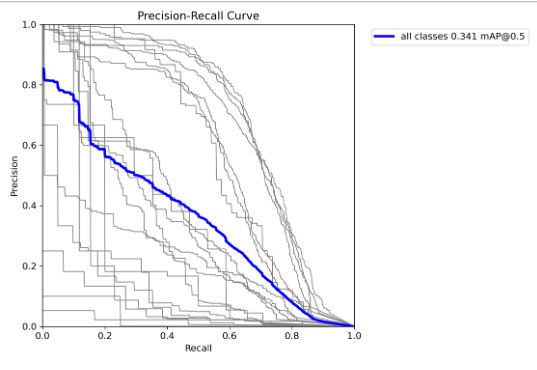

**Task 3.4.17:** Display the confusion matrix, which is already plotted for us in `confusion_matrix_normalized.png`.  Note which classes the model is most effective on.  Are they the same as those suggested by the precision-recall curves?

In [ ]:
Image.open(save_dir / "confusion_matrix_normalized.png")

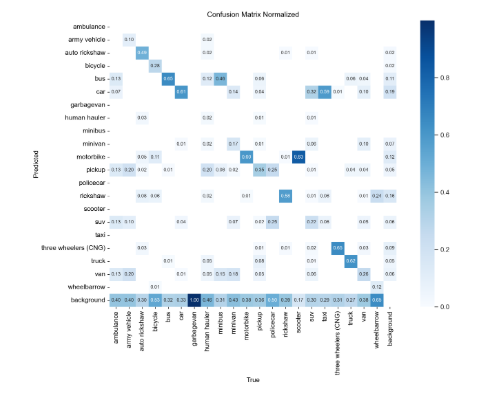

Data about the training process are available in the `results.csv` file.  We can load it in with pandas, although we need a few options to make the result look nice.

In [ ]:
df = pd.read_csv(save_dir / "results.csv", skipinitialspace=True).set_index(
    "epoch"
)
df.head()

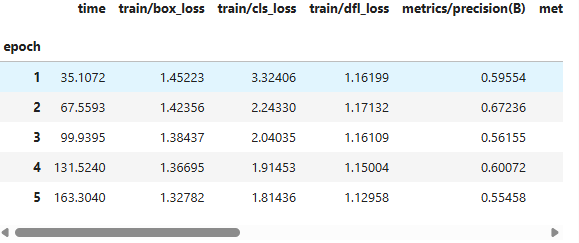

**Task 3.4.18:** Plot the classification loss over time for both the training and validation data.  Comparing these curves helps us understand if we are overfitting.

In [ ]:
%matplotlib

#output

Using matplotlib backend: module://matplotlib_inline.backend_inline

In [ ]:
# The `.plot` method on DataFrames may be useful.
df[['train/cls_loss', 'val/cls_loss']]

#output
	      train/cls_loss	val/cls_loss
epoch
  1	    3.32406	        2.15096
  2	    2.24330	        1.89784
  3	    2.04035	        1.70307
  4	    1.91453	        1.66555
  5	    1.81436	        1.53956
  6	    1.69731	        1.52783
  7	    1.64643	        1.45781
  8	    1.60452	        1.38921
  9	    1.55959	        1.35397
  10	  1.49348	        1.35495
  11	  1.47421	        1.32645
  12	  1.45796	        1.30748
  13	  1.39327	        1.28345
  14	  1.36218	        1.24901
  15	  1.33025	        1.23655
  16	  1.32454	        1.22760
  17	  1.29765	        1.20805
  18	  1.26183	        1.20061
  19	  1.25705	        1.19943
  20	  1.26351	        1.16991
  21	  1.22715	        1.19595
  22	  1.17552	        1.20375
  23	  1.15637	        1.16233
  24	  1.13574	        1.16542
  25	  1.11685	        1.15213
  26	  1.10356	        1.14492
  27	  1.07905	        1.13932
  28	  1.07165	        1.14068
  29	  1.06295	        1.13040
  30	  1.04781	        1.12563


In [ ]:
# The `.plot` method on DataFrames may be useful.
df[['train/cls_loss', 'val/cls_loss']].plot(marker='.');

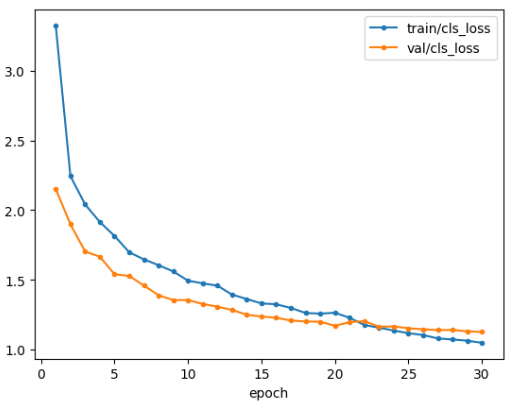

Snapshots of the model are saved in the `weights` subdirectory.  The weights for the last training epoch as well as the best performing epoch, as measured by the validation data, are saved.  This allows us to load the trained model to make predictions.

**Task 3.4.19:** Load the weights that gave the best performance.

In [ ]:
saved_model = YOLO(save_dir / "weights" / "best.pt")

print(saved_model)

**Task 3.4.20:** Conduct object detection on frame 600 that was extracted from the video.

In [ ]:
predict_results = saved_model.predict(
    "data_video/extracted_frames/frame_600.jpg", # Path to an image

    # Only return objects detected at this confidence level or higher
    conf=0.5,
    # Save output to disk
    save=True,
)

f"Results type: {type(predict_results)}, length {len(predict_results)}"


#output
image 1/1 /app/data_video/extracted_frames/frame_600.jpg: 384x640 7 cars, 1 suv, 3 three wheelers (CNG)s, 107.8ms
Speed: 3.6ms preprocess, 107.8ms inference, 244.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict3
"Results type: <class 'list'>, length 1"


This gives us a list with a single element. The bounding boxes detected are listed in the boxes attribute.

In [ ]:
predict_results[0].boxes

Some properties worth noting:
- `cls` lists the class indices
- `conf` gives the confidence of there being an object
- `xywh` lists the centers and sizes of the bounding boxes in pixels
- `xywhn` gives the same in normalized coordinates.
- `xyxy` and `xyxyn` give the corners of bounding boxes in pixels and normalized coordinate.

**Task 3.4.21:** Get the names of the classes of objects detected in this image.

In [ ]:
# Note that the tensor is on the GPU
predict_results[0].boxes.cls.cpu()

#output
tensor([ 5.,  5., 17.,  5., 17.,  5., 15., 17.,  5.,  5.,  5.])


**Get the names of the classes of objects detected in this image.**

In [ ]:
# To show the name of the classes of object instead of the indexes
[classes[int(ind)] for ind in predict_results[0].boxes.cls.cpu()]

#output
['car',
 'car',
 'three wheelers (CNG)',
 'car',
 'three wheelers (CNG)',
 'car',
 'suv',
 'three wheelers (CNG)',
 'car',
 'car',
 'car'
]

We could use the bounding box information to plot these objects on the image.  But with the `save=True` option we gave the predict call, this image has already been created for us:

In [ ]:
Image.open(pathlib.Path(predict_results[0].save_dir) / "frame_600.jpg")

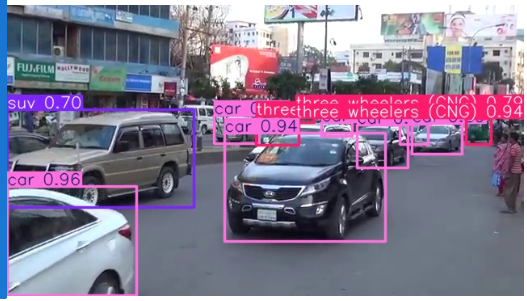